## Lead Mortality Analysis

Initial Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from scipy import stats

# Converted to csv since pandas wasn't playing nice
lead_df = pd.read_csv("lead_mortality-1.csv")
lead_df

,year,city,state,age,hardness,ph,infrate,typhoid_rate,np_tub_rate,mom_rate,population,precipitation,temperature,lead,foreign_share
0,1900,Alameda,CA,28.954838,97,7.6,0.109756,0.024390,0.030488,0.195122,164.0,1.850307,59.026169,0,0.193548
1,1900,Albany,NY,30.347675,43,7.3,0.298618,0.041445,0.013815,0.179596,941.0,3.278735,45.267910,1,0.184884
2,1900,Allegheny,PA,27.087301,111,7.3,0.446841,0.093991,0.027735,0.192604,1298.0,3.350943,48.971493,1,0.237302
3,1900,Allentown,PA,27.764046,176,7.7,0.384181,0.028249,0.005650,0.197740,354.0,3.350943,48.971493,1,0.078652
4,1900,Altoona,PA,27.037533,111,7.3,0.467866,0.043702,0.007712,0.182519,389.0,3.350943,48.971493,0,0.112601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1900,Wilmington,NC,28.554945,20,6.8,0.741627,0.100478,0.057416,0.229665,209.0,4.122792,59.117619,0,0.027473
168,1900,Woonsocket,RI,25.320946,2,5.7,0.744681,0.028369,0.039007,0.191489,282.0,3.646396,49.446857,1,0.500000
169,1900,Worcester,MA,28.088810,21,6.5,0.429054,0.025338,0.024493,0.184966,1184.0,3.613845,47.724197,0,0.309947
170,1900,Yonkers,NY,26.678278,110,7.1,0.446764,0.006263,0.039666,0.208768,479.0,3.278735,45.267910,1,0.329918


#### A. Compute the average infant mortality rate (Inf) for cities with lead pipes and for cities with non-lead pipes. Is there a statistically significant difference in the averages?


In [ ]:
lead_cities = lead_df[lead_df["lead"] == 1]["infrate"]
non_lead_cities = lead_df[lead_df["lead"] == 0]["infrate"]

avg_lead_infant_mortality_rate = lead_cities.mean()
avg_non_lead_infant_mortality_rate = non_lead_cities.mean()

print(f"{avg_lead_infant_mortality_rate=}")
print(f"{avg_non_lead_infant_mortality_rate=}")

# Perform t-test -- this method applies to means for two independent samples
t_stat, p_value = stats.ttest_ind(lead_cities, non_lead_cities)

print(f"{p_value=}")

avg_lead_infant_mortality_rate=0.4032575763188876
avg_non_lead_infant_mortality_rate=0.3811678507111289
p_value=0.37347109978795456


After performing a t-test, we see that we get With a p-value of 0.37347109978795456 which is much higher than the standard value of 0.05 which is used to determine statistical significance. So there is **not** a statistically significant difference.

#### B. The amount of lead leached from lead pipes depends on the chemistry of the water running through the pipes. The more acidic the water (that is, the lower the pH), the more lead is leached. Run a regression of Inf on Lead, pH, and the interaction term Lead ×pH.


In [11]:
# This regression function is equivalent to R's lm function
# The equation is defined by the first param, with the variables defined as described in the problem statement.
model = smf.ols("infrate ~ lead + ph + lead:ph", data=lead_df).fit()

print(f"{model.summary()=}")

model.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                infrate   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     20.91
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           1.47e-11
Time:                        01:32:01   Log-Likelihood:                 108.52
No. Observations:                 172   AIC:                            -209.0
Df Residuals:                     168   BIC:                            -196.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

##### I. The regression includes four coefficients (the intercept and the three coefficients multiplying the regressors). Explain what each coefficient measures.

- The intercept itself represents the baseline infant mortality rate for when lead and pH are both at 0. 
- The coefficient labeled "lead" is multiplied by the value of whether the city has lead or not. As this value is binary, it essentially just measures the expected difference in infant mortality rate between cities with lead and non-lead pipes.
- The coefficient labeled "pH" is multiplied by the value of pH in the city's water. This essentially measures how much the infant mortality rate changes according to increases in pH.
- The coefficient labeled "lead:ph" is multiplied by the value of whether the city has lead pipes multipled by pH. So this essentially measures any additional infant mortality rate changes due to the interactions between lead pipes in cities and water pH, with either affecting the other.

##### II. Plot the estimated regression function relating Inf to pH for Lead = 0 and Lead = 1. Describe the differences in the regression functions and relate these differences to the coefficients discussed in (I).

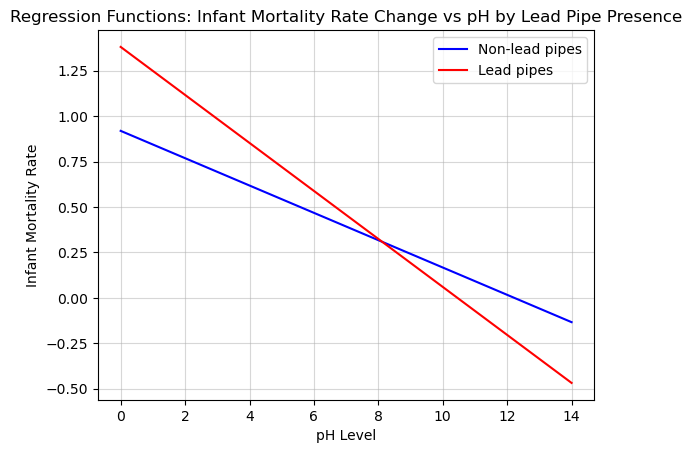

In [36]:
# First, grab the applicable coefficients:
intercept = model.params["Intercept"]
beta_lead = model.params["lead"]
beta_ph = model.params["ph"]
beta_lead_ph_interaction = model.params["lead:ph"]

# pH is only possible from 0 to 14. 100 points should be good
ph_range = np.linspace(0, 14, 100)

# Include lead parts for lead; don't include for non-lead
pred_lead = intercept + beta_lead + (beta_ph + beta_lead_ph_interaction) * ph_range
pred_non_lead = intercept + beta_ph * ph_range

plt.plot(ph_range, pred_non_lead, "blue", label="Non-lead pipes")
plt.plot(ph_range, pred_lead, "red", label="Lead pipes")

plt.xlabel("pH Level")
plt.ylabel("Infant Mortality Rate")
plt.title("Regression Functions: Infant Mortality Rate Change vs pH by Lead Pipe Presence")

plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


Between these two regression functions, we can see a few differences. Firstly, we see that the intercept is higher for lead pipes. This relates to the intercept coefficient we previously discussed, where the initial baseline infant mortality rate is therefore higher in cities with lead pipes. Secondly, we note that the slope is steeper for cities with lead pipes. This relates to the coefficient related to pH, where increases in pH lead to more drastic decreases in infant mortality rate in cities with lead pipes than those with non-lead pipes.



##### III. Does Lead have a statistically significant effect on infant mortality? Explain.

In [52]:
# Take the total effect of lead, which includes the interaction term
lead_coeff = model.params["lead"]
lead_pvalue = model.params["lead"]

lead_ph_interaction_coeff = model.params["lead:ph"]
lead_ph_interaction_pvalue = model.pvalues["lead:ph"]

print(f"{lead_coeff=}")
print(f"{lead_pvalue=}")

print(f"{lead_ph_interaction_coeff=}")
print(f"{lead_ph_interaction_pvalue=}")


lead_coeff=0.4617984571303253
lead_pvalue=0.4617984571303253
lead_ph_interaction_coeff=-0.05686221714936894
lead_ph_interaction_pvalue=0.06312008679405191


Both of the p-values of the lead interactions seem to not have statistically significant p-values (< 0.05), so it is likely that lead does not have a statistically significant effect on infant mortality.

##### IV. Does the effect of Lead on infant mortality depend on pH? Is this dependence statistically significant?

In [43]:
lead_ph_interaction_coeff = model.params["lead:ph"]
lead_ph_interaction_pvalue = model.pvalues["lead:ph"]

print(f"{lead_ph_interaction_coeff=}")
print(f"{lead_ph_interaction_pvalue=}")


lead_ph_interaction_coeff=-0.05686221714936894
lead_ph_interaction_pvalue=0.06312008679405191


There is a nonzero coefficient for the interaction term between lead and pH, so there seems to be some effect. However, the p-value fo the interaction term seems to suggest that this dependence is not statistically significant, with this being greater than the 0.05 threshold.

##### V. What is the average value of pH in the sample? At this pH level, what is the estimated effect of Lead on infant mortality? What is the standard deviation of pH? Suppose that the pH level is one standard deviation lower than the average level of pH in the sample; what is the estimated effect of Lead on infant mortality? What if pH is one standard deviation higher than the average value?

In [65]:
mean_ph = lead_df["ph"].mean()
print(f"{mean_ph=}")

lead_coeff = model.params["lead"]
lead_ph_interaction_coeff = model.params["lead:ph"]

def get_infrate_effect_of_lead_at_ph(ph):
    return lead_coeff + lead_ph_interaction_pvalue * ph

print(f"{get_infrate_effect_of_lead_at_ph(mean_ph)=}")

std_ph = lead_df["ph"].std()
print(f"{std_ph=}")

one_std_lower_than_avg_ph = mean_ph - std_ph
print(f"{one_std_lower_than_avg_ph=}")
print(f"{get_infrate_effect_of_lead_at_ph(one_std_lower_than_avg_ph)=}")

one_std_higher_than_avg_ph = mean_ph + std_ph
print(f"{one_std_higher_than_avg_ph=}")
print(f"{get_infrate_effect_of_lead_at_ph(one_std_higher_than_avg_ph)=}")

mean_ph=7.32267442137696
get_infrate_effect_of_lead_at_ph(mean_ph)=0.9240063021722229
std_ph=0.6917287508713886
one_std_lower_than_avg_ph=6.630945670505572
get_infrate_effect_of_lead_at_ph(one_std_lower_than_avg_ph)=0.8803443233792798
one_std_higher_than_avg_ph=8.014403172248349
get_infrate_effect_of_lead_at_ph(one_std_higher_than_avg_ph)=0.9676682809651661


##### VI. Construct a 95% confidence interval for the effect of Lead on infant mortality when pH = 6.5.


In [84]:
infrate_effect_of_lead_at_65_ph = get_infrate_effect_of_lead_at_ph(6.5)
print(f"{infrate_effect_of_lead_at_65_ph=}")

# Use t-test method to test the linear combination and find the standard error as a side result
test_result = model.t_test("lead + lead:ph * 6.5 = 0")
lead_standard_error = test_result.sd

# Find the critical t-value to multiple the standard error by to get the CI values
df = model.df_resid
alpha = 0.05
critical_t_value = stats.t.ppf(1 - alpha/2, df)

[infrate_effect_of_lead_at_65_ph - (lead_standard_error * critical_t_value), infrate_effect_of_lead_at_65_ph + (lead_standard_error * critical_t_value)]

infrate_effect_of_lead_at_65_ph=0.8720790212916627


[array([[0.81035908]]), array([[0.93379896]])]

#### C. The analysis in (b) may suffer from omitted variable bias because it neglects factors that affect infant mortality and that might potentially be correlated with Lead and pH. Investigate this concern, using the other variables in the data set.



In [15]:
neglected_factor_included_model = smf.ols("infrate ~ lead + ph + lead:ph + hardness + typhoid_rate + np_tub_rate + precipitation + temperature", data=lead_df).fit()
print(f"{neglected_factor_included_model.summary()=}")

print(f"{model.params['lead']=}")
print(f"{neglected_factor_included_model.params['lead']=}")
print(f"{model.params['ph']=}")
print(f"{neglected_factor_included_model.params['ph']=}")
print(f"{model.params['lead:ph']=}")
print(f"{neglected_factor_included_model.params['lead:ph']=}")

neglected_factor_included_model.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                infrate   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     15.73
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           4.69e-17
Time:                        01:37:34   Log-Likelihood:                 130.45
No. Observations:                 172   AIC:                            -242.9
Df Residuals:                     163   BIC:                            -214.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [17]:
everything_model = smf.ols("infrate ~ lead + ph + lead:ph + hardness + typhoid_rate + np_tub_rate + precipitation + temperature + population + mom_rate + age + foreign_share", data=lead_df).fit()
print(f"{everything_model.summary()=}")

print(f"{model.params['lead']=}")
print(f"{everything_model.params['lead']=}")
print(f"{model.params['ph']=}")
print(f"{everything_model.params['ph']=}")
print(f"{model.params['lead:ph']=}")
print(f"{everything_model.params['lead:ph']=}")

everything_model.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                infrate   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     16.96
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           6.56e-23
Time:                        01:41:56   Log-Likelihood:                 152.11
No. Observations:                 172   AIC:                            -278.2
Df Residuals:                     159   BIC:                            -237.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

We could possibly add the following factors to avoid omitted variable bias -- those specifically related to infant mortality and correlated with Lead and pH could be water hardness, typhoid rate, Non-pulmonary tuberculosis death rate, average precipitation, and average temperature in state. These seem to be more intuitively related to mortality and linked to lead pipes and pH than the others, so I began with these. We see that the coefficient for lead decreased by 0.01, which isn't a ton relative to the coefficient of 0.45, but the pH coefficient changed fairly drastically and more than halved to ~-0.036 from -0.075 in our original model. The lead-ph interaction term also increased by 0.001 which wasn't a ton relative to the coefficient of -0.055. So it seems that our concerns were somewhat founded, but maybe not as much for lead.

As this did change things but didn't move the needle a ton, for completeness I decided to include all other variables as well, except city/state/year which weren't really relevant to the model itself. In this "everything" model, we had a more significant decrease of the lead coefficient from ~-0.461 to ~0.406, an even more significant decrease in magnitude of the pH coefficient from ~-0.075 to ~-0.028, and the lead-ph interaction coefficient changed from ~-0.0569 to ~-0.0516. So there were more changes in the coefficients here, and it seems to indicate that adding these other factors made a difference and seems to imply that there was previously some level of omitted variabl biasis due to correlated terms.